# ML: Breast Cancer Dataset Cleaning

## Part 0: Pre-requisites 

### Imports

In [4]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

### Function to plot the learning curve 

In [7]:
def plot_learning_curves(model, x_train, y_train, x_val, y_val):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

### Function to split the data 

In [8]:
def train_val_test_split(x, y):
    # Splitting into training (80%) and temporary set (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=3)
    # Splitting the temporary set into validation (50%) and test (50%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=3)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [9]:
# Used locally 
path = "C:\\Users\\Hp\\OneDrive - American University of Beirut\\CMPS M\\Spring 23-24\\CMPS 396V\\project\\ML_Breast_Cancer\\Models\\"

# Used to load and save models for later use

def saveModel(fileName, model):
  with open(path + fileName, 'wb') as f:
      pickle.dump(model, f)

def getModel(fileName):
  with open(path + fileName, 'rb') as f:
      loaded_model = pickle.load(f)
  return loaded_model

In [10]:
results = [] # Array used to store tuples of (model, accuracy_score)

## Part 1: Data 


### Load the data 

In [30]:
data = pd.read_csv("data.csv", encoding="utf-8")
data.head()

C:\Users\Hp\AppData\Local\Temp\ipykernel_1852\3240169054.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="utf-8")


,cancer_type,patient_id,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,474,54.29,High,1,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,7029,43.45,Moderate,0,LumA,4,Positve,Positive,1.0,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,5215,74.11,High,0,LumB,3,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,5412,51.87,High,0,LumA,3,Positve,Positive,2.0,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,465,87.18,Moderate,0,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print(data.shape)

(1496, 688)


In [13]:
print(data[data['cancer_type'] == "Breast Invasive Ductal Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Invasive Lobular Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Mixed Ductal and Lobular Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Invasive Mixed Mucinous Carcinoma"].shape[0])

1199
114
165
18


↪ Our dataset is imbalanced
- we cannot undersample due to the fact that our dataset is mall
- random oversampling may lead to overfitting
- there are other techniques for oversamplign (**SMOTE**)
- setting class weights in an inversely prop way to its freq.
- **boosting** and **bagging** models, **random forest** model are good options.
- use **f1-score** or any metric that is sensitive to data imbalance.  

### Clean the data

#### Remove missing and duplicate values from dataset

In [24]:
# Check and remove missing values from the dataset
data.isna().sum()
data.dropna(axis=0, inplace=True)
data.reset_index(inplace=True, drop = True) # added drop = True, so that no new column is added for index

In [25]:
data.shape

(874, 688)

↪ 41.5% of the data was removed!

In [26]:
# Check and remove duplicate values from the dataset
data.duplicated().sum()
data.drop_duplicates(inplace=True)

↪ We don't have duplicated data.

#### Features with null values

In [14]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [31]:
missing_values_table(data)

Your selected dataframe has 688 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
tumor_stage,395,26.4
3-gene_classifier_subtype,166,11.1
primary_tumor_laterality,76,5.1
neoplasm_histologic_grade,52,3.5
cellularity,40,2.7
mutation_count,31,2.1
er_status_measured_by_ihc,23,1.5
tumor_size,12,0.8
death_from_cancer,1,0.1


It is only reasonable to remove columns when 60-70% null values. 
But this does not apply to any of the above columns. In addition, All the above features are important in our classification problem.
So the deletion approach is not preferable.
Other approaches are imputation (replace by mode, mean, median, at random from dataset, KNN imputation), dummy variables, or using models that handle missing values.

##### Imputation of Null Values: 

In [32]:
# imputing with the mode value
from sklearn.impute import SimpleImputer
data = data.copy()
# data = data.drop(columns = "patient_id")
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent') # strategy can also be mean or median 
data.iloc[:,:] = mean_imputer.fit_transform(data)

In [33]:
missing_values_table(data)

Your selected dataframe has 688 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Split the data into train, validation, and test sets 

Given the dataset size (around 1500) we can go with either approach (spliting the data manualy or applying cross-validation)

Split the dataset into train (80%), validation (10%) and test (10%) sets

In [55]:
# dealing with categorical data
''' 
cancer_type
cellularity 
pam50_+_claudin-low_subtype 
er_status_measured_by_ihc
er_status
her2_status_measured_by_snp6
her2_status_measured_by_snp6
inferred_menopausal_state
primary_tumor_laterality
pr_status
3-gene_classifier_subtype
death_from_cancer
'''

# unnecessary features
'''
patient_id
'''

In [34]:
y = data["cancer_type"]
x = data.drop(columns = ["cancer_type","patient_id"])

x_encoded = pd.get_dummies(x)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(x_encoded, y_encoded)

## Part 3: Models

### Logistic Regression

In [37]:
# Initialize and train Logistic Regression model
log_reg_model = LogisticRegression(solver='liblinear', max_iter=200)  
log_reg_model.fit(x_train, y_train)  # Fit the data 

# Predict on validation data
log_reg_predictions = log_reg_model.predict(x_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, log_reg_predictions)
# accuracy = f1_score(y_val, log_reg_predictions, average="weighted")

print("Accuracy:", accuracy)

saveModel('imputed_data_models\\log_reg_model.pkl', log_reg_model)

Accuracy: 0.7333333333333333


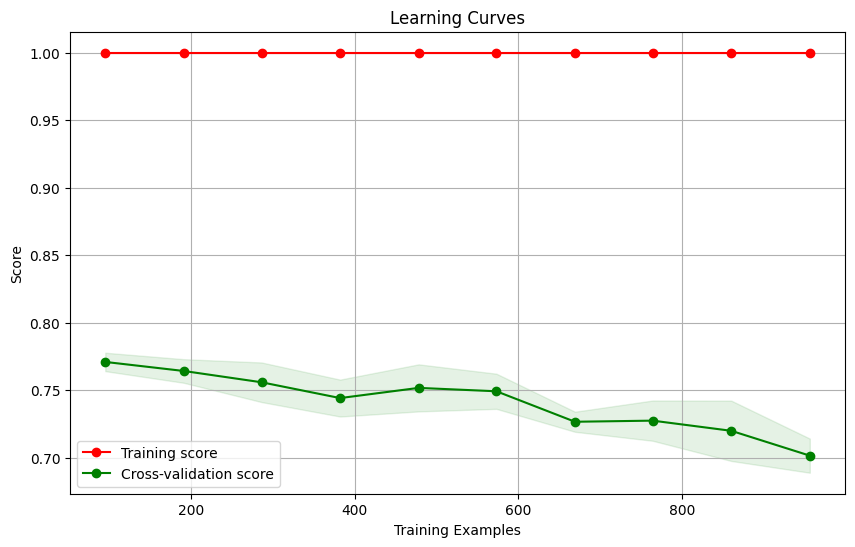

In [36]:
# Plot learning curve 
plot_learning_curves(log_reg_model, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [38]:
log_reg_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [18]:
log_reg_model = getModel("imputed_data_models\\log_reg_model.pkl")

In [47]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
# Create the grid search object
grid_search = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, cv=5)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the model with the best hyperparameters on the entire training dataset
best_model = grid_search.best_estimator_

val_score = best_model.score(x_val, y_val)
print("Validation Set Accuracy:", val_score)

saveModel('imputed_data_models\\log_reg_best.pkl', best_model)

c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.799334030683403
Validation Set Accuracy: 0.8066666666666666


### Random Forest

In [39]:
# initialize and train the Random Forest model
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

# predict labels for the validation set
rf_clf_predictions = rf_clf.predict(x_val)

# report the validation accuracy of the trained model
accuracy = accuracy_score(rf_clf_predictions, y_val)
print("Accuracy (Random Forest):", accuracy)

saveModel('imputed_data_models\\rf_clf.pkl', rf_clf)

Accuracy (Random Forest): 0.8066666666666666


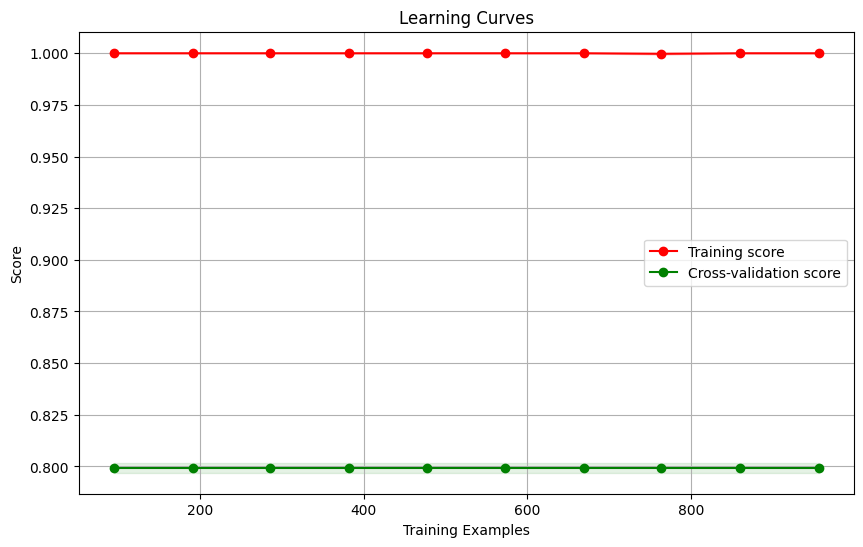

In [46]:
plot_learning_curves(rf_clf, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [40]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [48]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10], # should we increase? 500 - 1200
    'min_samples_leaf': [1, 2, 4], # increase to 100 - 500
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 1)

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the model with the best hyperparameters on the entire training dataset
best_model = grid_search.best_estimator_
val_pred = best_model.predict(x_val)

# Evaluate accuracy on the validation set
val_score = best_model.score(val_pred, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('imputed_data_models\\rf_clf_best.pkl', best_model)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score: 0.799334030683403


c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### SVM

In [41]:
# initialize and train the Support Vector Machines model
svm_clf = SVC()
svm_clf.fit(x_train, y_train)

# report the number of support vectors
num_support_vectors = svm_clf.n_support_
print("Number of support vectors for each class:", num_support_vectors)

# predict labels for the validation set
val_pred = svm_clf.predict(x_val)

# report the validation accuracy of the trained model
accuracy = accuracy_score(val_pred, y_val)
print("Accuracy:", accuracy)

saveModel('imputed_data_models\\svm_clf.pkl', svm_clf)

Number of support vectors for each class: [557  90  16 134]
Accuracy: 0.8066666666666666


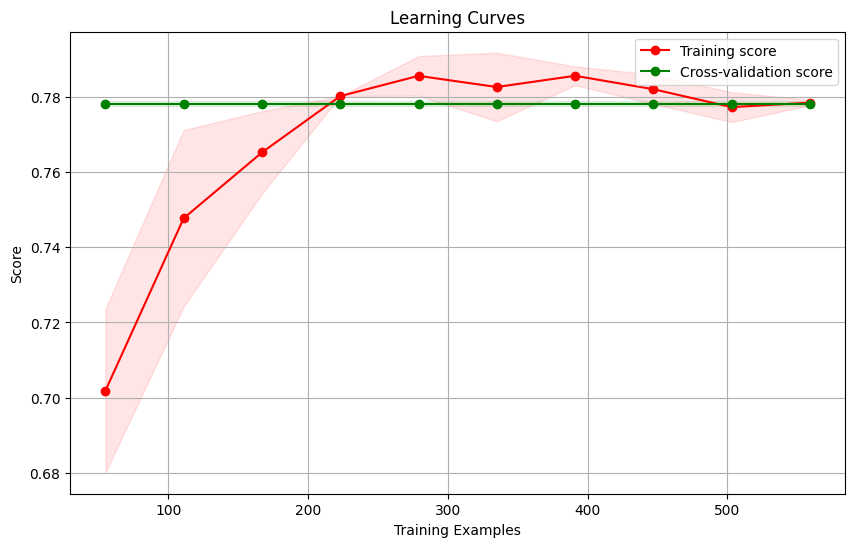

In [ ]:
plot_learning_curves(svm_clf, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [20]:
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# Define the parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 1)

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Predict on the validation set with the best model
best_model = grid_search.best_estimator_
val_pred = best_model.predict(x_val)

# Evaluate accuracy on the validation set
val_score = best_model.score(val_pred, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('imputed_data_models\\svm_clf_best.pkl', best_model)

### Gradient Boosting 

In [42]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train, y_train)

# predict labels for the validation set
val_pred = gb_clf.predict(x_val)

# report the validation accuracy of the trained model
accuracy = accuracy_score(y_val, val_pred)
print("Accuracy on validation set:", accuracy)

saveModel('imputed_data_models\\gb_clf.pkl', gb_clf)

Accuracy on validation set: 0.82


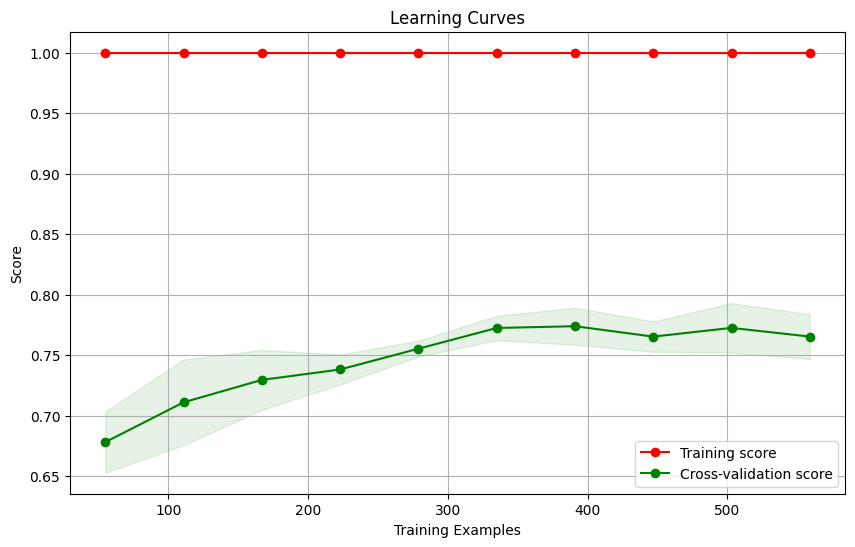

In [ ]:
plot_learning_curves(gb_clf, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning 

In [43]:
gb_clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_grid = {
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=None, verbose = 1) # cv = None?

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the model with the best hyperparameters on the entire training dataset
best_model = grid_search.best_estimator_

val_score = best_model.score(x_val, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('imputed_data_models\\gb_clf_best.pkl', best_model)

### Neural Network

In [44]:
# Modify the create_dense_model function to create an MLPClassifier model
def create_mlp_model():
    model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000)
    return model

# function to extract the dense model from the pipeline
def extract_model(pipeline):
    return pipeline.steps[-1][1]

# Create a pipeline for the MLPClassifier model
mlp_pipeline = Pipeline([
    ('flatten', FunctionTransformer(lambda x: x.reshape((x.shape[0], -1)))),
    ('mlp', create_mlp_model())
])

# train the network
nn_model = extract_model(mlp_pipeline)
nn_model.fit(x_train, y_train)

# predict labels for the validation set
val_pred = nn_model.predict(x_val)

# report the validation accuracy of the trained model
accuracy = accuracy_score(y_val, val_pred)
print("Validation accuracy:", accuracy)

saveModel('imputed_data_models\\nn_model.pkl', nn_model)

Validation accuracy: 0.7333333333333333


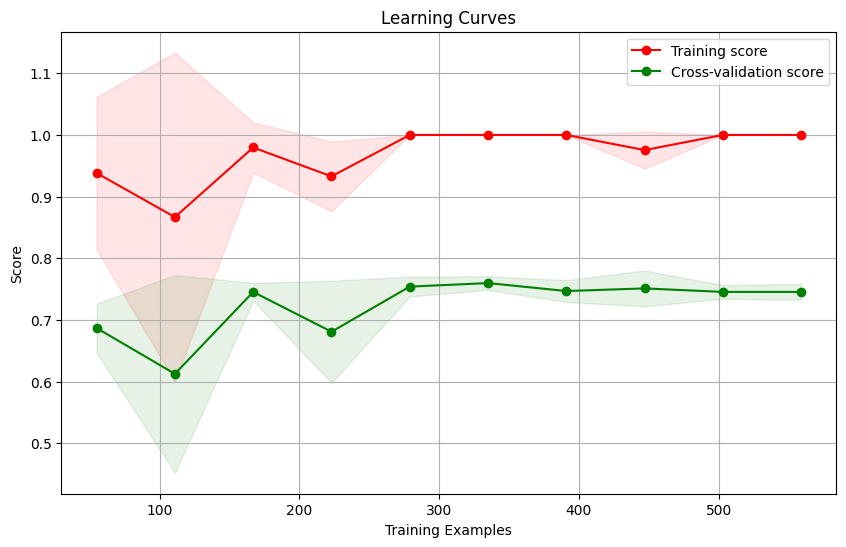

In [25]:
plot_learning_curves(nn_model, x_train, y_train, x_val, y_val)

#### Hyperparameter Tuning

In [55]:
nn_model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (128, 64),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
param_dist = {
    # 'hidden_layers': [1, 3, 5],  # Number of hidden layers
    # 'units': [50, 100, 150, 200],       # Number of units in hidden layers
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    # 'learning_rate': [0.01, 0.1, 0.2],
    'batch_size': [32, 64, 128]
}

# print(nn_model.get_params().keys())

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(nn_model, param_dist, n_iter=50, cv=5, verbose = 1)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_
val_pred = best_model.predict(x_val)

# Evaluate accuracy on the validation set
val_score = best_model.score(val_pred, y_val)
print("Validation Set Accuracy:", val_score)

results.append((best_model, val_score))

saveModel('imputed_data_models\\nn_model_best.pkl', best_model)